# Spatial Analysis and Visualizations

This notebook can be used to extract and visualize the spatial features used in the model (Forward Voronoi area, Team influence, and Blocker influence). 

Steps:
1) Load and preprocess required data from raw data files 
2) Select a play to extract the spatial features from 
3) Create the voronoi diagram and extract forward voronoi area 
4) Create and visualize the team influence map
5) Create and visualize the blocker influence map

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from spatial import get_areas_from_points, get_positions_from_dataframe, get_influence_for_frame, plot_influence_grid, plot_voronoi_cells, plot_players, get_influence_for_blockers
from data_preprocessing import aggregate_data, restore_geometry
from data_cleaning import clean_data, optimize_memory_usage

root_dir = os.getcwd()
%load_ext autoreload
%autoreload 2

In [2]:
# import data and create aggregate dataframe
plays_fname = os.path.join(root_dir, "data/plays.csv")
players_fname = os.path.join(root_dir, "data/players.csv")
tackles_fname = os.path.join(root_dir, "data/tackles.csv")
tracking_fname_list = [os.path.join(root_dir, f"data/tracking_week_{i}.csv") for i in range(1,10)]

# Aggregate data from the plays.csv, players.csv, tackles.csv, and any tracking data into one aggregate dataframe.
df = aggregate_data(plays_fname, tackles_fname, players_fname, tracking_fname_list)

# Preprocess and clean the data
df_clean = clean_data(df)

# optimize memory usage of dataframe
df_opt = optimize_memory_usage(df_clean)

print("INFO: ... Done")

INFO: Aggregating data from play data, tracking data, tackles data, and players data into a master dataframe...
INFO: Transforming orientation and direction angles so that 0° points from left to right, and increasing angle goes counterclockwise...
INFO: Flipping plays so that they all run from left to right...
INFO: Labeling plays as runs or passes
INFO: Removing play with penalties...
INFO: 566852 rows removed
INFO: Converting teams from str to numeric...
INFO: Memory usage reduced from 17749903482 to 15794972922
INFO: Removing inactive frames...
INFO: 2325620 rows removed
INFO: Removing bad data...
INFO: 0 rows removed
INFO: Removing unused columns from dataframe...
INFO: 46 columns removed
INFO: Converting geometry variables from floats to int...
INFO: Memory usage reduced from 1292833142 to 977297966
INFO: Downcasting integers and floats...
INFO: Memory usage reduced from 977297966 to 652997924
INFO: ... Done


In [3]:
# import tackle data and annotate which frames tackles and missed tackles occured on

df_tackles = pd.read_csv(tackles_fname)

groupby = df_opt.groupby(["gameId", "playId"])
tackle_sum = df_tackles.tackle.sum()
missedTackle_sum = df_tackles.pff_missedTackle.sum()
print("DATA SUMMARY: ")
print(" =================== ")
print(f"There are {len(groupby)} unique plays in the tracking data.")
print(f"Within these plays there are {tackle_sum} tackles and {missedTackle_sum} missed tackles")


DATA SUMMARY: 
There are 11875 unique plays in the tracking data.
Within these plays there are 9919 tackles and 2090 missed tackles


In [4]:
# select a play to get the point_dict that will be used for voronoi analysis 
gameId = 2022110601
playId = 1027
frameId = 30
print(f"{gameId}, {playId}, {frameId}")

this_tackle = df_tackles[(df_tackles.playId == playId) & (df_tackles.gameId == gameId)]
df_frame = df_opt[(df_opt.playId == playId) & (df_opt.gameId == gameId) & (df_opt.frameId == frameId)].copy()
df_frame = restore_geometry(df_frame)
point_dict = get_positions_from_dataframe(df_frame)


2022110601, 1027, 30


In [5]:
# extract the voronoi cell areas for each player
offenseId = df_frame[df_frame.club == df_frame.possessionTeam].nflId.values
defenseId = df_frame[df_frame.club == df_frame.defensiveTeam].nflId.values
ballCarrierId = df_frame.ballCarrierId.values[0]
tacklerId = this_tackle.nflId.values[0]
area_dict = get_areas_from_points(point_dict, ballCarrierId, restriction=5)

print(f"Area of the ballcarrier ({ballCarrierId}) = {area_dict[ballCarrierId]:.2f}")
area_dict

Area of the ballcarrier (46377) = 7.28


{46377.0: 7.282770317985069,
 44925.0: 266.50539617963113,
 45009.0: 99.23641637652463,
 45345.0: 19.53509799854146,
 46153.0: 1.922532196102111,
 52458.0: 244.3029918653924,
 54504.0: 366.82450500894197,
 54513.0: 21.25821527601329,
 52563.0: 12.937569099177153,
 40023.0: 102.68890070958082,
 43454.0: 133.52587118660335,
 46119.0: 9.038866996882462,
 52413.0: 154.77374207784283,
 52447.0: 1.6716589329930684,
 53435.0: 177.82056617209486,
 46192.0: 39.97888210399674,
 48233.0: 685.7988900879727,
 43447.0: 4.315795660376807,
 41599.0: 59.84135320340147,
 47973.0: 3.884116413723632,
 53861.0: 7.095793465582119,
 54781.0: 51.02022002497688}

In [6]:
# Build the team influence model
df_frame = df_opt[(df_opt.playId == playId) & (df_opt.gameId == gameId) & (df_opt.frameId == frameId)].copy()
df_frame = restore_geometry(df_frame)

influence_dict, team_influence_fn = get_influence_for_frame(df_frame)

<Figure size 640x480 with 0 Axes>

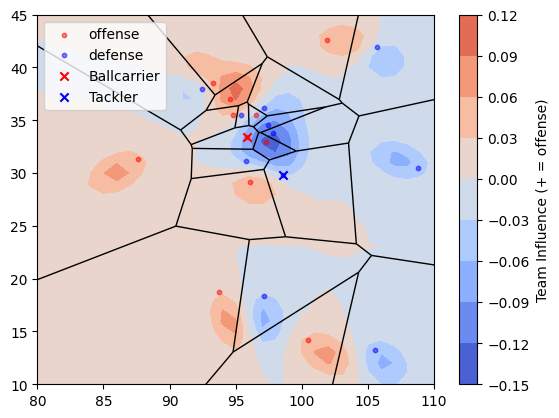

In [7]:
# plot results 

plt.figure()
xx, yy = np.meshgrid(np.linspace(80, 110, 31), np.linspace(10, 45, 36))
plot_voronoi_cells(point_dict, xlim=[80, 110], ylim=[10, 45])
plot_influence_grid(team_influence_fn, (xx, yy), cmap_range=[-0.15, 0.15])
plot_players(point_dict, offenseIds=offenseId, defenseIds=defenseId, ballcarrierId=ballCarrierId, tacklerId=tacklerId, marker_size=10)
plt.show()

In [8]:
# build the blocker influence model 
df_frame = df_opt[(df_opt.playId == playId) & (df_opt.gameId == gameId) & (df_opt.frameId == frameId)].copy()
df_frame = restore_geometry(df_frame)

blocker_influence_dict, blocker_influence_fn = get_influence_for_blockers(df_frame)

<Figure size 640x480 with 0 Axes>

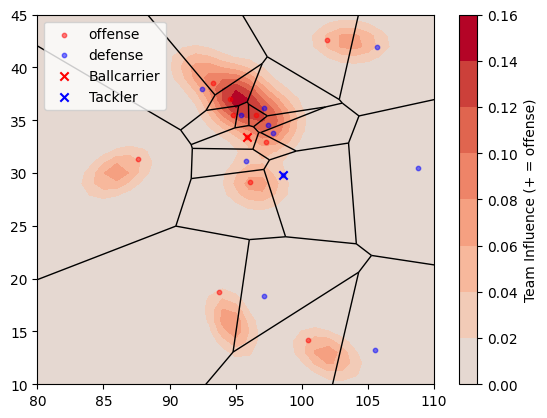

In [9]:
# plot results 

plt.figure()
xx, yy = np.meshgrid(np.linspace(80, 110, 31), np.linspace(10, 45, 36))
plot_voronoi_cells(point_dict, xlim=[80, 110], ylim=[10, 45])
plot_influence_grid(blocker_influence_fn, (xx, yy), cmap_range=[-0.15, 0.15])
plot_players(point_dict, offenseIds=offenseId, defenseIds=defenseId, ballcarrierId=ballCarrierId, tacklerId=tacklerId, marker_size=10)
plt.show()